## Project Design: Clustering and Bottleneck Identification

The goal of this project is to identify bottlenecks in the delivery process using clustering techniques (K-means) and principal component analysis (PCA). After clustering, we will examine how different factors (such as agent age, traffic, and delivery distance) influence delays in deliveries. By understanding these clusters, we can diagnose where bottlenecks are occurring and suggest solutions.

#### Key Features for Clustering:
- Agent_Age: Age of the delivery agent.
- Agent_Rating: Rating of the agent’s performance.
- Store_Latitude & Store_Longitude: Location of the store.
- Drop_Latitude & Drop_Longitude: Delivery drop-off location.
- Weather: Categorical, needs encoding.
- Traffic: Categorical, needs encoding.
- Vehicle: Categorical, needs encoding.
- Area: Categorical, needs encoding.
- Category: Categorical, needs encoding.
- Delivery_Time: Time taken for delivery (target to identify bottleneck).

#### Dataset: https://www.kaggle.com/datasets/sujalsuthar/amazon-delivery-dataset/data

In [43]:
import pandas as pd
df = pd.read_csv('amazon_delivery.csv')

In [44]:
df.dropna(inplace=True)
df

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43734,jlxf819993117,30,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,11:35:00,11:45:00,Windy,High,motorcycle,Metropolitian,160,Home
43735,aevx342135787,21,4.6,0.000000,0.000000,0.070000,0.070000,2022-02-16,19:55:00,20:10:00,Windy,Jam,motorcycle,Metropolitian,180,Jewelry
43736,xnek760674819,30,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,23:50:00,00:05:00,Cloudy,Low,scooter,Metropolitian,80,Home
43737,cynl434665991,20,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,13:35:00,13:40:00,Cloudy,High,motorcycle,Metropolitian,130,Kitchen


In [45]:
# Calculate distance between store and drop off area

import math

def haversine_distance(store_lat, store_lon, drop_lat, drop_lon):
    # convert from degrees to radians
    store_lat, store_lon, drop_lat, drop_lon = map(math.radians, [store_lat, store_lon, drop_lat, drop_lon])

    # Haversine formula
    dlat = drop_lat - store_lat
    dlon = drop_lon - store_lon
    a = math.sin(dlat / 2)**2 + math.cos(store_lat) * math.cos(drop_lat) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Radius of Earth in kilometers. Use 3956 for miles. 
    R = 6371
    distance = R * c

    return distance

df['Distance'] = df.apply(lambda row: haversine_distance(row['Store_Latitude'], row['Store_Longitude'],
                                                         row['Drop_Latitude'], row['Drop_Longitude']), axis=1)

# Dropping rows that don't give enough useful information for the tests
df.drop(['Store_Latitude','Store_Longitude','Drop_Latitude','Drop_Longitude','Order_Date','Order_Time','Pickup_Time'],axis=1,inplace=True)
df

,Order_ID,Agent_Age,Agent_Rating,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,Distance
0,ialx566343618,37,4.9,Sunny,High,motorcycle,Urban,120,Clothing,3.025149
1,akqg208421122,34,4.5,Stormy,Jam,scooter,Metropolitian,165,Electronics,20.183530
2,njpu434582536,23,4.4,Sandstorms,Low,motorcycle,Urban,130,Sports,1.552758
3,rjto796129700,38,4.7,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics,7.790401
4,zguw716275638,32,4.6,Cloudy,High,scooter,Metropolitian,150,Toys,6.210138
...,...,...,...,...,...,...,...,...,...,...
43734,jlxf819993117,30,4.8,Windy,High,motorcycle,Metropolitian,160,Home,1.489846
43735,aevx342135787,21,4.6,Windy,Jam,motorcycle,Metropolitian,180,Jewelry,11.007735
43736,xnek760674819,30,4.9,Cloudy,Low,scooter,Metropolitian,80,Home,4.657195
43737,cynl434665991,20,4.7,Cloudy,High,motorcycle,Metropolitian,130,Kitchen,6.232393


In [46]:
df.set_index('Order_ID',inplace=True)
df

,Agent_Age,Agent_Rating,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,Distance
Order_ID,,,,,,,,,
ialx566343618,37,4.9,Sunny,High,motorcycle,Urban,120,Clothing,3.025149
akqg208421122,34,4.5,Stormy,Jam,scooter,Metropolitian,165,Electronics,20.183530
njpu434582536,23,4.4,Sandstorms,Low,motorcycle,Urban,130,Sports,1.552758
rjto796129700,38,4.7,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics,7.790401
zguw716275638,32,4.6,Cloudy,High,scooter,Metropolitian,150,Toys,6.210138
...,...,...,...,...,...,...,...,...,...
jlxf819993117,30,4.8,Windy,High,motorcycle,Metropolitian,160,Home,1.489846
aevx342135787,21,4.6,Windy,Jam,motorcycle,Metropolitian,180,Jewelry,11.007735
xnek760674819,30,4.9,Cloudy,Low,scooter,Metropolitian,80,Home,4.657195


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

le = LabelEncoder()
df['Weather_encoded'] = le.fit_transform(df['Weather'])
df['Traffic_encoded'] = le.fit_transform(df['Traffic'])
df['Vehicle_encoded'] = le.fit_transform(df['Vehicle'])
df['Area_encoded'] = le.fit_transform(df['Area'])
df['Category_encoded'] = le.fit_transform(df['Category'])

df_encoded = df.copy()
df_encoded = df.drop(['Weather','Traffic','Vehicle','Area','Category'],axis=1)
heatmap_data=df_encoded.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# Apply elbow method to get optimal amount of clusters
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=30)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

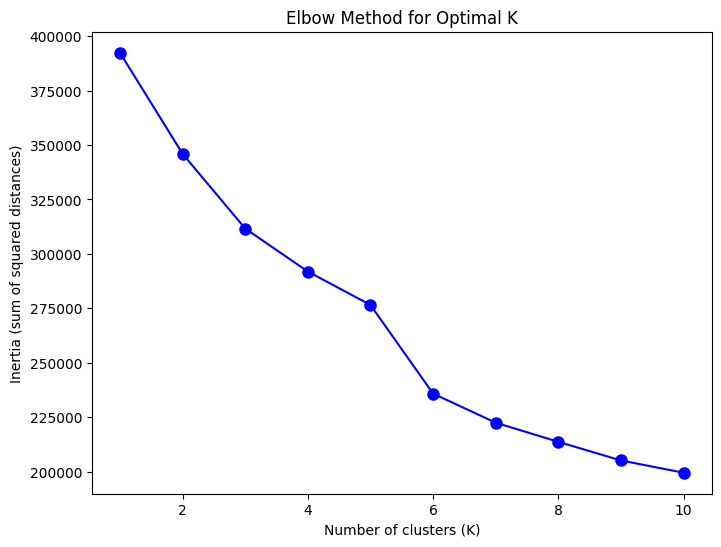

In [48]:
# Plotting the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, 'bo-', markersize=8)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia (sum of squared distances)')
plt.show()

In [49]:
optimal_k = 6  # Based on the Elbow method or Silhouette score (where learning slows)
kmeans = KMeans(n_clusters=optimal_k, random_state=30)
df_encoded['Cluster'] = kmeans.fit_predict(X_scaled)

In [50]:
df_encoded.groupby('Cluster').mean()


,Agent_Age,Agent_Rating,Delivery_Time,Distance,Weather_encoded,Traffic_encoded,Vehicle_encoded,Area_encoded,Category_encoded
Cluster,,,,,,,,,
0,28.500398,4.718437,100.965126,10.035813,2.629899,1.837328,0.542202,2.999205,7.454163
1,24.406709,4.730685,91.733441,10.650717,2.790799,1.913110,0.529020,0.049590,7.218846
2,30.188755,4.725677,171.674569,10.817757,0.940795,1.139008,0.296152,0.133178,8.086022
3,32.355781,4.033551,180.397183,12.268734,2.562790,1.544065,0.446487,0.371586,7.472771
4,34.704149,4.736926,116.014255,9.623640,3.187766,2.011809,0.606809,0.032447,7.434468
5,29.814815,4.634815,120.592593,5243.684868,2.511111,1.666667,0.488889,0.777778,7.777778


# Cluster Analysis

## Cluster Names and Characteristics

### Cluster 0: Young Efficient Deliveries
- **Agent Age**: ~28.5
- **Agent Rating**: ~4.72 (high)
- **Delivery Time**: ~101 minutes
- **Distance**: ~10 km
- **Characteristics**: Relatively younger agents with high ratings and moderate delivery times.

### Cluster 1: Young Fast Deliveries
- **Agent Age**: ~24.4
- **Agent Rating**: ~4.73 (high)
- **Delivery Time**: ~92 minutes
- **Distance**: ~10.7 km
- **Characteristics**: Very young agents, slightly faster deliveries compared to Cluster 0.

### Cluster 2: Mature Long Deliveries
- **Agent Age**: ~30.2
- **Agent Rating**: ~4.73 (high)
- **Delivery Time**: ~172 minutes (long)
- **Distance**: ~10.8 km
- **Characteristics**: Older agents with very long delivery times.

### Cluster 3: Older Delayed Deliveries
- **Agent Age**: ~32.4
- **Agent Rating**: ~4.03 (lower)
- **Delivery Time**: ~180 minutes (very long)
- **Distance**: ~12.3 km
- **Characteristics**: Older agents with lower ratings and the longest delivery times.

### Cluster 4: Experienced Steady Deliveries
- **Agent Age**: ~34.7
- **Agent Rating**: ~4.74 (high)
- **Delivery Time**: ~116 minutes (moderate)
- **Distance**: ~9.6 km
- **Characteristics**: Older agents, high ratings, and moderate delivery times.

### Cluster 5: Outlier Deliveries
- **Agent Age**: ~29.8
- **Agent Rating**: ~4.63 (high)
- **Delivery Time**: ~121 minutes (long)
- **Distance**: ~5243 km (anomaly; likely an outlier)
- **Characteristics**: This cluster has an exceptionally high distance value, suggesting it might be an outlier or erroneous data.

## Summary of Suggested Cluster Names
- **Cluster 0**: Young Efficient Deliveries
- **Cluster 1**: Young Fast Deliveries
- **Cluster 2**: Mature Long Deliveries
- **Cluster 3**: Older Delayed Deliveries
- **Cluster 4**: Experienced Steady Deliveries
- **Cluster 5**: Outlier Deliveries


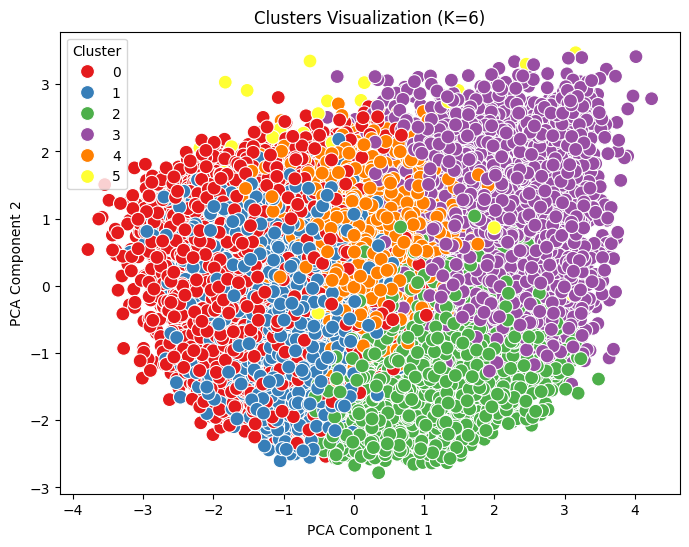

In [51]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_encoded['Cluster'], palette='Set1', s=100)
plt.title(f'Clusters Visualization (K={optimal_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [52]:
pca_components = pd.DataFrame(pca.components_, columns=df_encoded.columns[:-1],index=['Component 1', 'Component 2'])
pca_components

,Agent_Age,Agent_Rating,Delivery_Time,Distance,Weather_encoded,Traffic_encoded,Vehicle_encoded,Area_encoded,Category_encoded
Component 1,0.407037,-0.466951,0.647314,0.003903,-0.168222,-0.226727,-0.171549,-0.287363,0.074405
Component 2,0.284215,-0.348443,-0.102823,0.051125,0.817424,0.046309,0.074685,0.096585,-0.315262


# PCA Analysis

## PCA Components and Loadings

### Component 1
- **Agent Age**: 0.407037
- **Agent Rating**: -0.466951
- **Delivery Time**: 0.647314
- **Distance**: 0.003903
- **Weather Encoded**: -0.168222
- **Traffic Encoded**: -0.226727
- **Vehicle Encoded**: -0.171549
- **Area Encoded**: -0.287363
- **Category Encoded**: 0.074405

### Component 2
- **Agent Age**: 0.284215
- **Agent Rating**: -0.348443
- **Delivery Time**: -0.102823
- **Distance**: 0.051125
- **Weather Encoded**: 0.817424
- **Traffic Encoded**: 0.046309
- **Vehicle Encoded**: 0.074685
- **Area Encoded**: 0.096585
- **Category Encoded**: -0.315262

## Summary of PCA Component Contributions
- **Component 1** is influenced most by **Delivery Time** and **Agent Age**, indicating it captures variations related to these features.
- **Component 2** is heavily influenced by **Weather Encoded**, showing its importance in this component's variance.


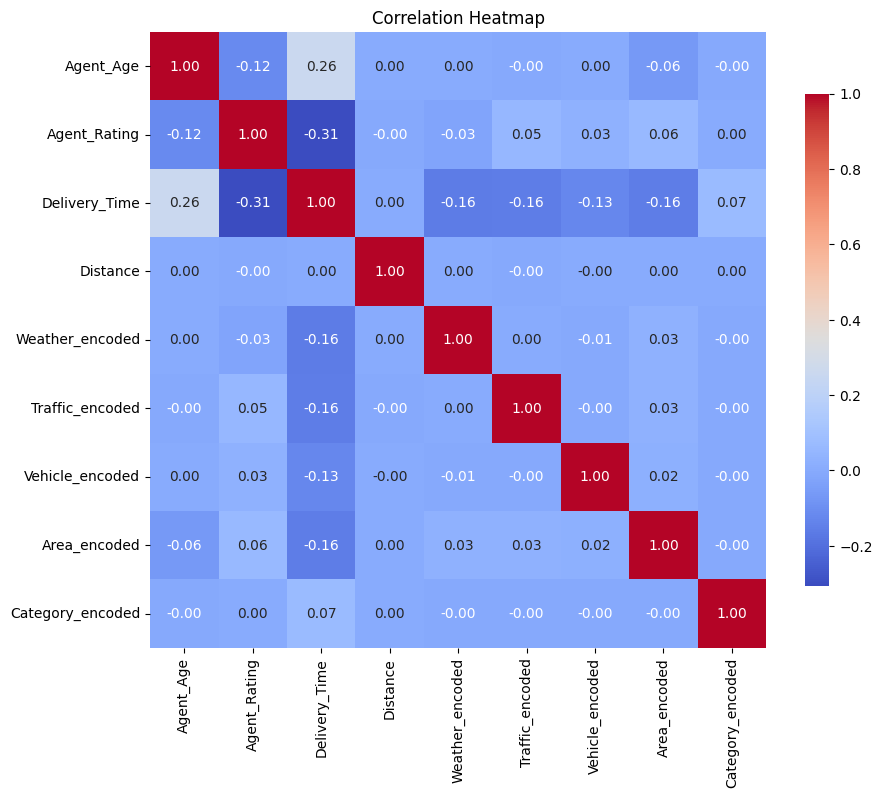

In [53]:
# Correlation Matrix and Heat Map Creation

correlation_matrix = heatmap_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap with annotations
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Title and labels
plt.title('Correlation Heatmap')
plt.show()

# Summary of Delivery Time Correlations

1. **Agent Age**:
   - There is a **positive correlation (0.26)** between `Agent_Age` and `Delivery_Time`, indicating that as the age of the agent increases, delivery time tends to increase slightly. However, this correlation is moderate and may not be very strong.

2. **Agent Rating**:
   - A **negative correlation (-0.31)** exists between `Agent_Rating` and `Delivery_Time`, suggesting that higher agent ratings are associated with shorter delivery times. This indicates that more highly-rated agents tend to deliver more efficiently.

3. **Distance**:
   - The correlation between `Distance` and `Delivery_Time` is **nearly zero (0.0003)**, indicating that there is virtually no relationship between the distance of deliveries and the time taken for those deliveries in this dataset.

4. **Weather Encoded**:
   - A **negative correlation (-0.16)** is observed between `Weather_encoded` and `Delivery_Time`. This suggests that certain weather conditions might lead to longer delivery times, though the relationship is weak.

5. **Traffic Encoded**:
   - Similarly, there is a **negative correlation (-0.16)** between `Traffic_encoded` and `Delivery_Time`, indicating that higher traffic levels may also correlate with longer delivery times.

6. **Vehicle Encoded**:
   - The correlation with `Delivery_Time` is also **negative (-0.13)**, suggesting that different vehicle types may have a slight impact on delivery efficiency, although the effect appears to be weak.

7. **Area Encoded**:
   - There is a **negative correlation (-0.16)** between `Area_encoded` and `Delivery_Time`, suggesting that deliveries in certain areas may be associated with longer times.

8. **Category Encoded**:
   - The correlation here is **very weak (0.07)**, indicating that the category of the delivery has little to no effect on delivery time.

## Conclusion
The most notable findings from the heatmap are:
- **Agent Rating** is the strongest predictor of delivery time, with higher ratings correlating to shorter delivery times.
- **Agent Age** has a positive correlation with delivery time, suggesting that older agents may take longer, though this relationship is moderate.
- **Distance** does not significantly impact delivery time based on the data.
- **Weather, Traffic, Vehicle, and Area** all show weak negative correlations with delivery time, suggesting potential influences but warranting further investigation.

These insights can guide operational strategies, such as focusing on improving agent training and evaluating the impact of traffic and weather conditions on delivery performance.


# Key Insights and Hypothesis from K-Means, PCA, and Heatmap

## Key Insights
1. **Agent Rating as a Predictor**:
   - **Strong negative correlation (-0.31)** between **Agent Rating** and **Delivery Time** suggests that higher-rated agents deliver faster.

2. **Agent Age Influence**:
   - A **positive correlation (0.26)** with **Agent Age** indicates older agents may take longer, warranting further investigation into their performance.

3. **Cluster Findings**:
   - Clusters reveal that certain agent characteristics correlate with longer delivery times, suggesting opportunities for targeted improvements.

4. **Weather and Traffic Effects**:
   - Both **Weather** and **Traffic** show slight negative correlations with delivery time, indicating external factors impacting efficiency.

## Key Proposal
**Proposal**: "Improving agent training and support for older agents will significantly reduce delivery times, particularly for those with lower agent ratings."

This hypothesis can be tested by implementing targeted training programs and measuring subsequent changes in delivery efficiency.
